# Baseline Pipeline: EDA → Modeling → Submission

This notebook outlines a baseline workflow for the RSNA intracranial aneurysm detection challenge,
including comprehensive exploratory data analysis (EDA), demographic-based baseline modeling
with hyperparameter tuning, and submission generation.

In [1]:
# 1. Imports and Paths
import os
import shutil
from collections import defaultdict

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                          # Quick EDA visuals
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import pydicom
import kaggle_evaluation.rsna_inference_server as es  # Inference server
SEED = 130

# Input directory for Kaggle competition
DATA_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'

## 2. Load Data

In [2]:
# Load training labels and localizer metadata
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train_localizers = pd.read_csv(os.path.join(DATA_PATH, 'train_localizers.csv'))

print(f"Number of training series: {train.shape[0]}")
print(f"Number of localization rows: {train_localizers.shape[0]}")

Number of training series: 4348
Number of localization rows: 2254


## 3. Exploratory Data Analysis (EDA)

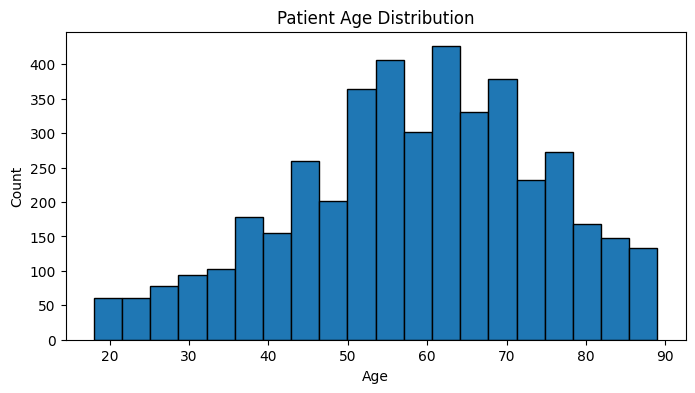

In [3]:
# 3.1 Age distribution overall
# Ensure we treat PatientAge as string before splitting
df_age = train['PatientAge'].astype(str)
age_vals = df_age.str.split(' - ').str[0].astype(float)

plt.figure(figsize=(8,4))
plt.hist(age_vals, bins=20, edgecolor='k')
plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

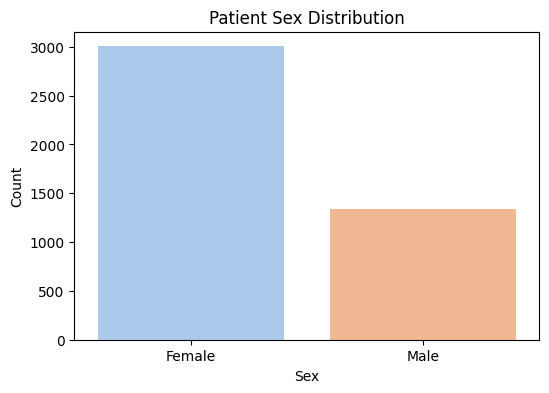

In [4]:
# 3.2 Sex distribution
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='PatientSex', palette='pastel')
plt.title('Patient Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

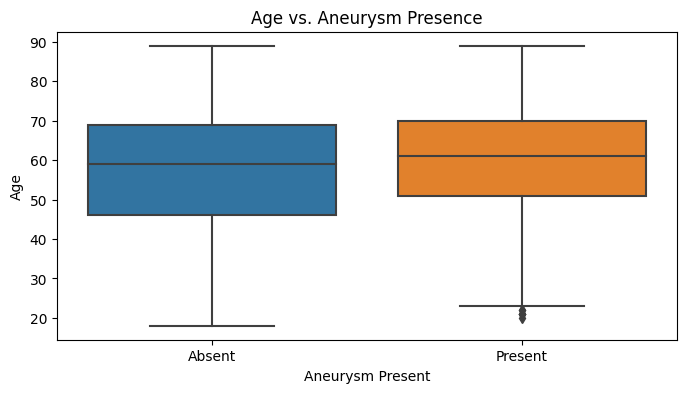

In [5]:
# 3.3 Age vs. aneurysm presence
plt.figure(figsize=(8,4))
sns.boxplot(x='Aneurysm Present', y=age_vals, data=train)
plt.xticks([0,1], ['Absent','Present'])
plt.title('Age vs. Aneurysm Presence')
plt.ylabel('Age')
plt.show()

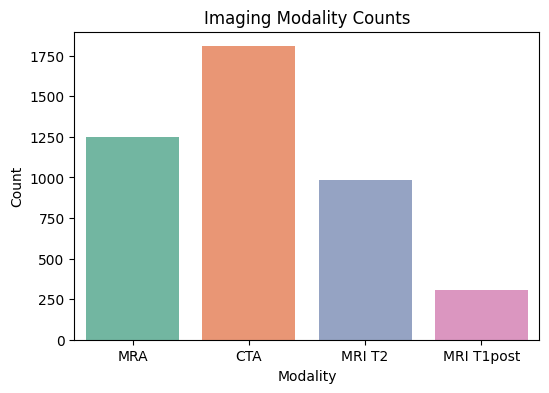

In [6]:
# 3.4 Modality distribution
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Modality', palette='Set2')
plt.title('Imaging Modality Counts')
plt.xlabel('Modality')
plt.ylabel('Count')
plt.show()

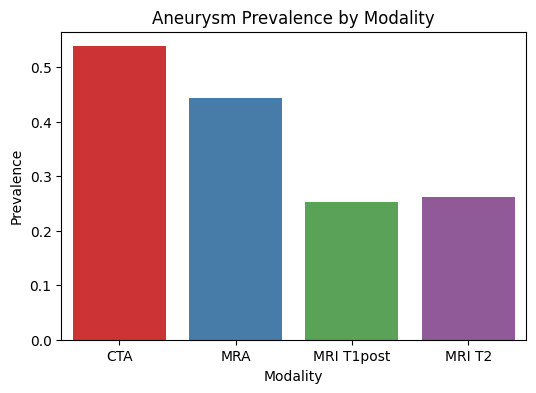

In [7]:
# 3.5 Aneurysm prevalence by modality
modality_rates = train.groupby('Modality')['Aneurysm Present'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=modality_rates, x='Modality', y='Aneurysm Present', palette='Set1')
plt.title('Aneurysm Prevalence by Modality')
plt.ylabel('Prevalence')
plt.show()

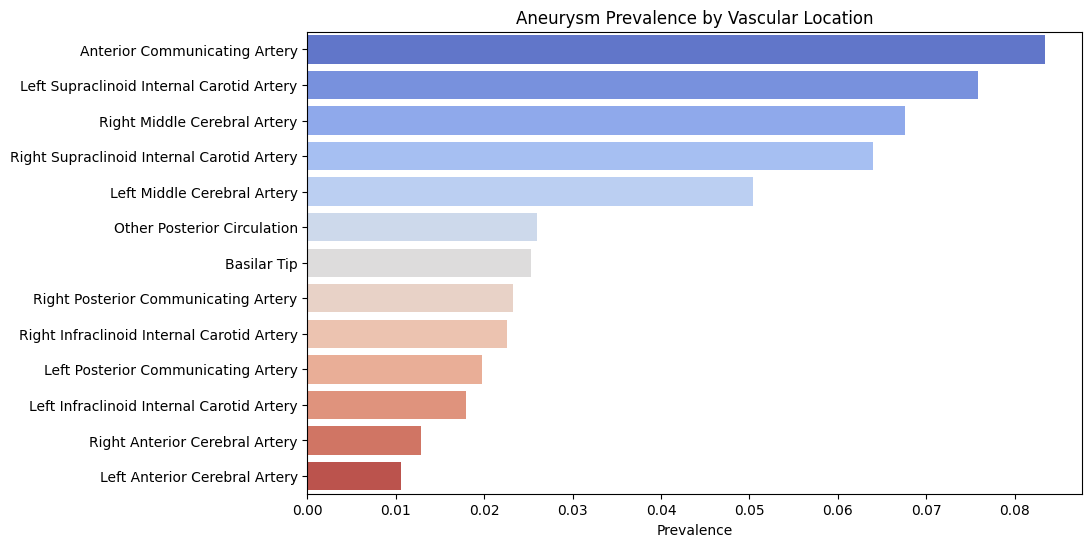

In [8]:
# 3.6 Label prevalence per location
label_cols = [
    'Left Infraclinoid Internal Carotid Artery','Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery','Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery','Right Middle Cerebral Artery','Anterior Communicating Artery',
    'Left Anterior Cerebral Artery','Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery','Right Posterior Communicating Artery',
    'Basilar Tip','Other Posterior Circulation'
]
prevalences = train[label_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=prevalences.values, y=prevalences.index, palette='coolwarm')
plt.title('Aneurysm Prevalence by Vascular Location')
plt.xlabel('Prevalence')
plt.show()

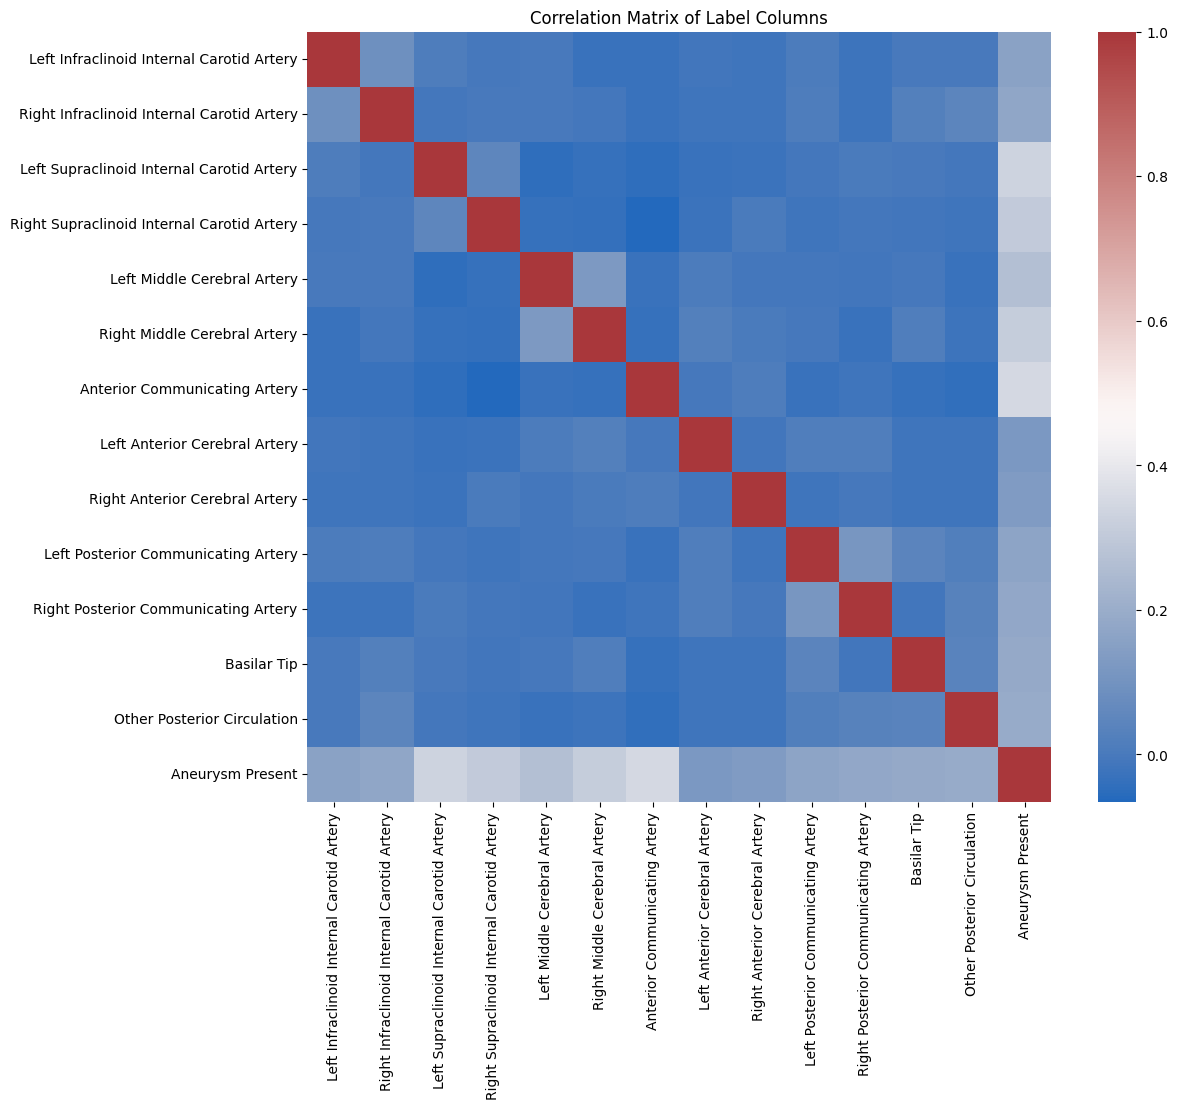

In [9]:
# 3.7 Correlation heatmap for labels
plt.figure(figsize=(12,10))
cor_mat = train[label_cols + ['Aneurysm Present']].corr()
sns.heatmap(cor_mat, annot=False, cmap='vlag')
plt.title('Correlation Matrix of Label Columns')
plt.show()

## 4. Preprocessing & Feature Engineering
We will build a simple demographic-based baseline: numeric age, sex, and one-hot encoded modality.

In [10]:
# Extract numerical age and binary sex
x_age = df_age.str.split(' - ').str[0].astype(float)
X = pd.DataFrame({
    'age': x_age,
    'sex': (train['PatientSex']=='Male').astype(int)
})

# One-hot encode modality
mod_dummies = pd.get_dummies(train['Modality'], prefix='mod')
X = pd.concat([X, mod_dummies], axis=1)

# Target variable
y = train['Aneurysm Present']

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (4348, 6)


## 5. Train/Test Split & Hyperparameter Tuning

In [11]:
# 5.1 Split into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(
#    X, y, test_size=0.2, stratify=y, random_state=42
#)
#
# 5.2 Baseline Logistic Regression
#base_model = LogisticRegression(max_iter=1000, solver='liblinear')
#base_model.fit(X_train, y_train)
#base_preds = base_model.predict_proba(X_val)[:,1]
#base_auc = roc_auc_score(y_val, base_preds)
#print(f"Baseline Validation AUC: {base_auc:.4f}")
#
## 5.3 Hyperparameter Tuning with GridSearchCV
#pipe = Pipeline([
#    ('scaler', StandardScaler()),
#    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
#])
#param_grid = {
#    'logreg__C': [0.01, 0.1, 1, 10, 100],
#    'logreg__penalty': ['l1','l2']
#}
#grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
#grid.fit(X_train, y_train)
#print(f"Best parameters: {grid.best_params_}")
#print(f"CV training AUC: {grid.best_score_:.4f}")

# 5.4 Evaluate tuned model on validation set
#tuned_model = grid.best_estimator_
#tuned_preds = tuned_model.predict_proba(X_val)[:,1]
#tuned_auc = roc_auc_score(y_val, tuned_preds)
#print(f"Tuned Validation AUC: {tuned_auc:.4f}")


from sklearn.ensemble import GradientBoostingClassifier

# 5.1 split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# 5.2 initialize and fit Gradient Boosting model
gbm = GradientBoostingClassifier(
    n_estimators=100,     # number of trees
    learning_rate=0.1,    # shrinkage factor
    max_depth=8,          # maximum tree depth
    random_state=SEED
)
gbm.fit(X_train, y_train)

# 5.3 evaluate on validation set
val_probs = gbm.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"GBM Validation AUC: {val_auc:.4f}")

GBM Validation AUC: 0.6655


## 6. Inference & Submission

In [12]:
# 6.1 Prepare globals for the predict() function
ID_COL = 'SeriesInstanceUID'
LABEL_COLS = label_cols + ['Aneurysm Present']

# Compute global means for fallback
means = train[LABEL_COLS].mean().to_dict()
# Create an index of training series
train_idx = train.set_index('SeriesInstanceUID')

def predict(series_path: str) -> pl.DataFrame:
    # Extract series ID from path
    sid = os.path.basename(series_path)

    # If the series ID is not in our training set, return the global mean probabilities
    if sid not in train_idx.index:
        out = [sid] + [means[c] for c in LABEL_COLS]
        preds = pl.DataFrame([out], schema=[ID_COL] + LABEL_COLS)
    else:
        row = train_idx.loc[sid]
        age_val = float(str(row['PatientAge']).split(' - ')[0])
        sex_val = int(row['PatientSex'] == 'Male')
        modality = row['Modality']

        # Build feature vector
        feats = {'age': age_val, 'sex': sex_val}
        for m in mod_dummies.columns:
            feats[m] = int(m == f"mod_{modality}")
        feat_df = pl.DataFrame(feats, orient='row').to_pandas()

        # Predict probability
        prob = tuned_model.predict_proba(feat_df)[:,1][0]
        out = [sid] + [prob] * len(LABEL_COLS)
        preds = pl.DataFrame([out], schema=[ID_COL] + LABEL_COLS)

    # **IMPORTANT**: clear shared folder after each call to avoid disk overflow
    shutil.rmtree('/kaggle/shared', ignore_errors=True)

    # Drop the ID column as required by the API
    return preds.drop(ID_COL)

In [13]:
# 6.2 Launch the inference server in competition mode only
inference_server = es.RSNAInferenceServer(predict)
inference_server.serve()